In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

In [11]:
# Load the FITS file
filename = "http://72.233.250.83/data/ecam/20231021/ecam-0034.fits"
hdul = fits.open(filename)

data = hdul[0].data.astype(np.float32)
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
EXTEND  =                    T                                                  
DATE-OBS= '2023-10-21T06:36:04.659'                                             
EXP_TIME=                  5.0 / Exposure Time (Seconds)                        
EXP_TYPE= 'Single  '           / Exposure Type (Single, Real Time, or Series)   
IMG_TYPE= 'Object  '           / Image Type (Bias, Flat, Dark, or Object)       
FILTER  = 'V       '           / Filter (Ha, B, V, g, r)                        
TEMP    = '-79.25  '           / CCD Temperature during Exposure                
COMMENT                     

In [25]:
import sep

# data = data.byteswap().newbyteorder()
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)
signal = data - bkg
sources = sep.extract(signal, 1.5, err=bkg.globalrms, minarea=40)

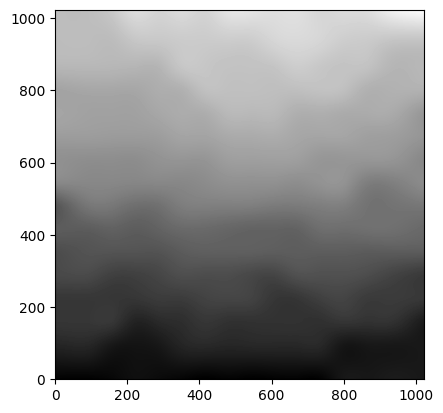

In [26]:
bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')


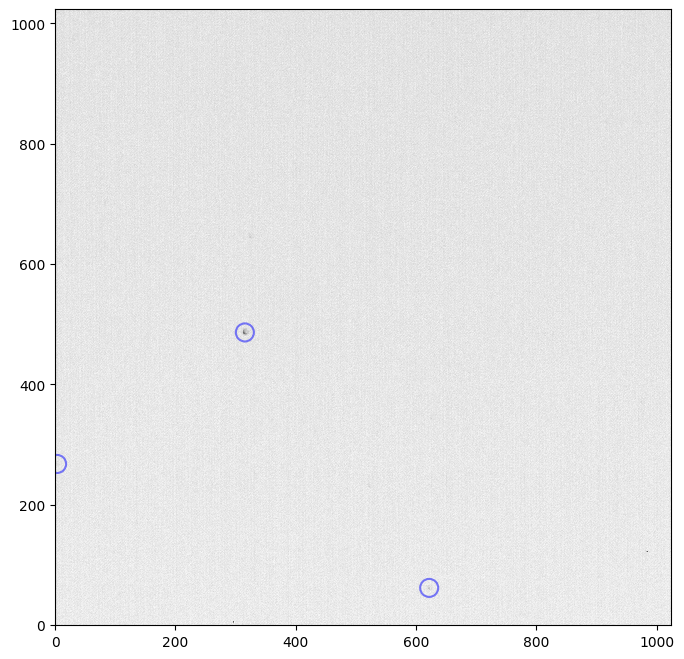

In [27]:
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((sources['x'], sources['y']))
apertures = CircularAperture(positions, r=15.0)
norm = ImageNormalize(stretch=AsinhStretch())
fig = plt.figure(figsize=(10, 8))  # Adjust the width (10) and height (8) as desired
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5);

In [28]:
sources

array([(16.31433678,  53,  43, 619, 626,  58,  66, 621.7670686 ,  61.61410818, 3.12319721, 3.84568567, -0.40340838, 0.00699656, 0.00855986, -1.12249096e-03, 2.00647807, 1.71549678, -1.1505543 , 0.32458258, 0.2636033 , 0.06809674,  1935.33532715,  2034.58251953, 101.59666443, 154.72161865, 621,  61, 621,  61, 0),
       (16.31433678,  44,  34,   1,   7, 264, 272,   3.22861538, 267.65749898, 2.49744448, 4.58872297, -0.72872859, 0.01120554, 0.0219491 , -3.06976556e-03, 2.19490457, 1.50617445, -1.26646781, 0.41986531, 0.22851463, 0.13335644,  1153.63085938,  1233.12939453,  46.45956421,  74.27203369,   3, 267,   2, 267, 0),
       (16.31433678, 138, 130, 310, 323, 481, 493, 315.38014061, 486.29851995, 6.87344181, 7.89232908, -0.23436936, 0.00137207, 0.00132633,  3.96801723e-05, 2.81844902, 2.61191821, -1.35520649, 0.14563498, 0.12683374, 0.00864951, 11819.17578125, 12027.42675781, 357.9800415 , 472.6675415 , 314, 485, 314, 485, 0)],
      dtype=[('thresh', '<f8'), ('npix', '<i8'), ('tnpix'

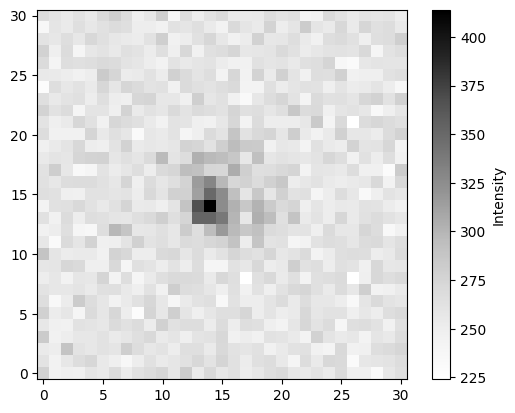

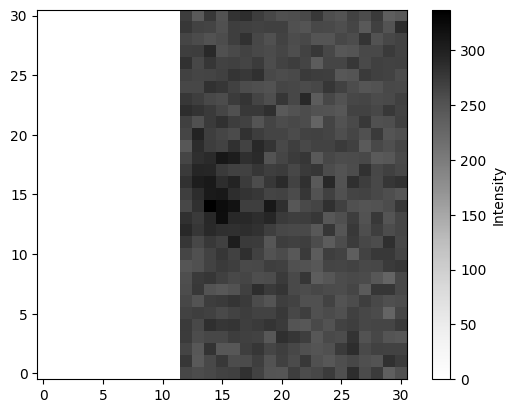

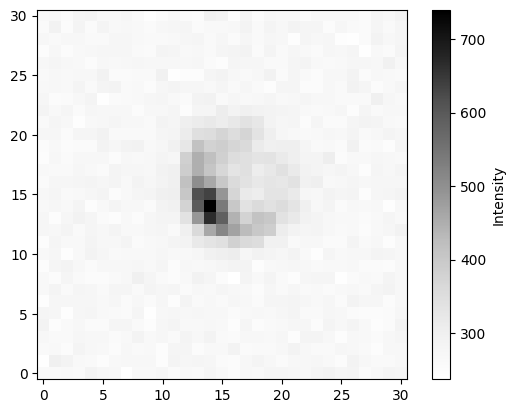

In [29]:
def plot_aperature(data, aperture):
    mask = aperture.to_mask(method='center')
    roi_data = mask.cutout(data)
    plt.imshow(roi_data, cmap='Greys', origin='lower')
    plt.colorbar(label='Intensity')
    plt.show()

for ap in apertures:
    plot_aperature(data, ap)

In [15]:
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
# def calc_hfd(data, bg, aperture):
#     total_flux = aperture_photometry(data-bg, aperture)['aperture_sum'][0]

#     mask = aperture.to_mask(method='center')
#     roi_data = mask.cutout(data-bg)
#     dist_weighted_flux = 0
#     for (y,x), pix in np.ndenumerate(roi_data):
#         dist = np.sqrt(y*y+x*x)
#         if  dist < aperture_r:
#             dist_weighted_flux += pix * dist
#     return dist_weighted_flux / total_flux * 2
APERTURE_R = 10

def calc_hfd(signal, aperture):
    mask = aperture.to_mask(method='center')
    roi_data = mask.cutout(signal)
    dist_weighted_flux = 0
    for (y, x), pix in np.ndenumerate(roi_data):
        dist = np.sqrt(y*y+x*x)
        if dist < APERTURE_R:
            dist_weighted_flux += pix * dist

    # total_flux = aperture_photometry(signal, aperture)['aperture_sum'][0]
    total_flux = np.sum(roi_data)
    return dist_weighted_flux / total_flux * 2

263.0


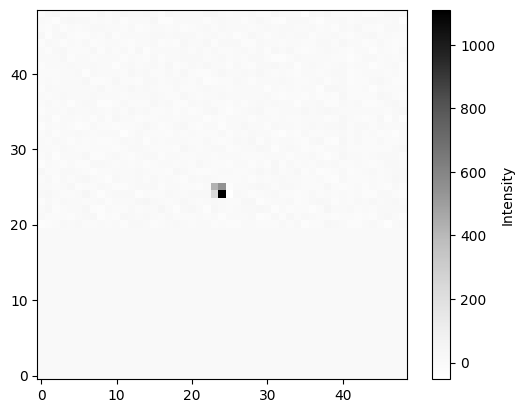

274.0


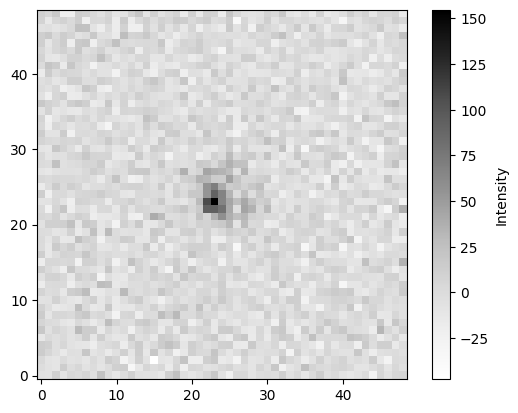

273.0


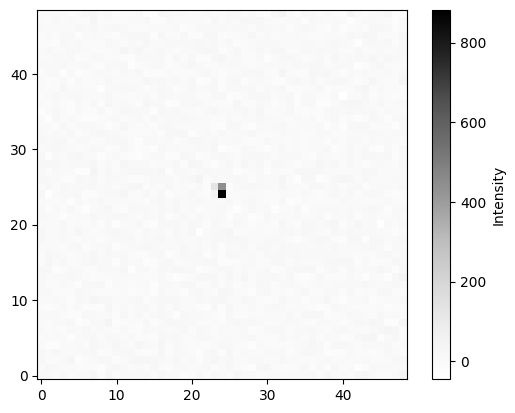

247.0


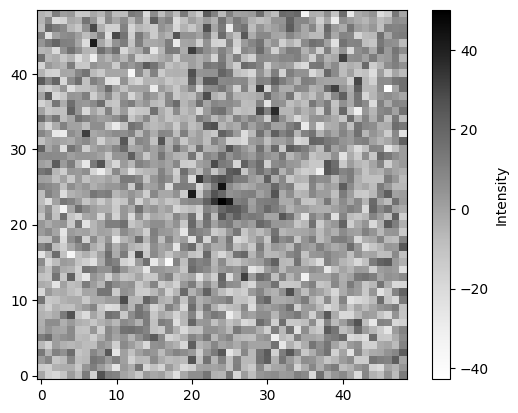

278.0


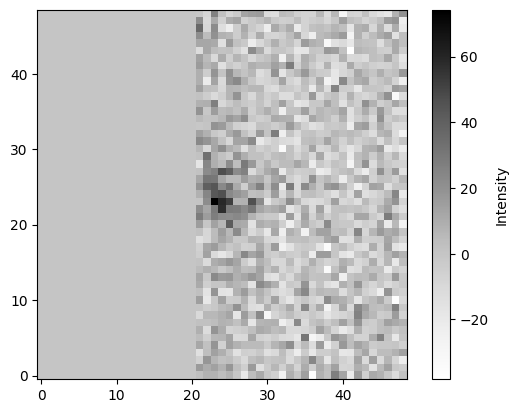

275.0


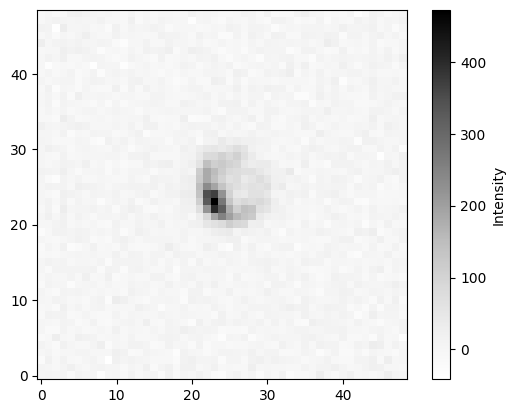

275.0


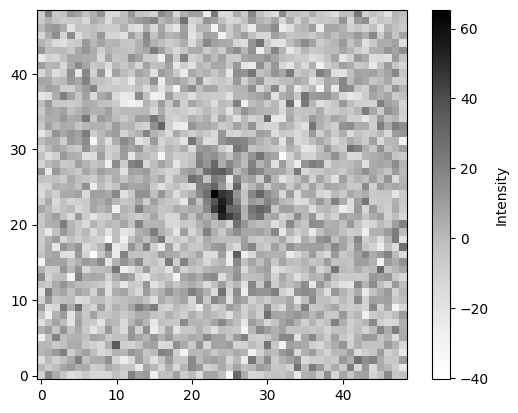

In [16]:
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile

# Extract the x and y coordinates of the detected stars
x_coords = sources['x']
y_coords = sources['y']

# Calculate the FWHM for each detected star
fwhm_values = []
hfd_values = []

for x, y in zip(x_coords, y_coords):
    # xycen = centroid_quadratic(data, xpeak=x, ypeak=y)
    xycen = (x, y)
    print(data[int(x), int(y)]) 
    # TODO: check if the star is not saturated
    edge_radii = np.arange(25)
    rp = RadialProfile(signal, xycen, edge_radii, mask=None)
    fwhm_value = rp.gaussian_fwhm
    fwhm_values.append(fwhm_value)
    plot_aperature(signal, rp.apertures[-1])

    # HFD
    aperture = CircularAperture((x, y), r=APERTURE_R)
    hfd = calc_hfd(signal, aperture)
    hfd_values.append(hfd)

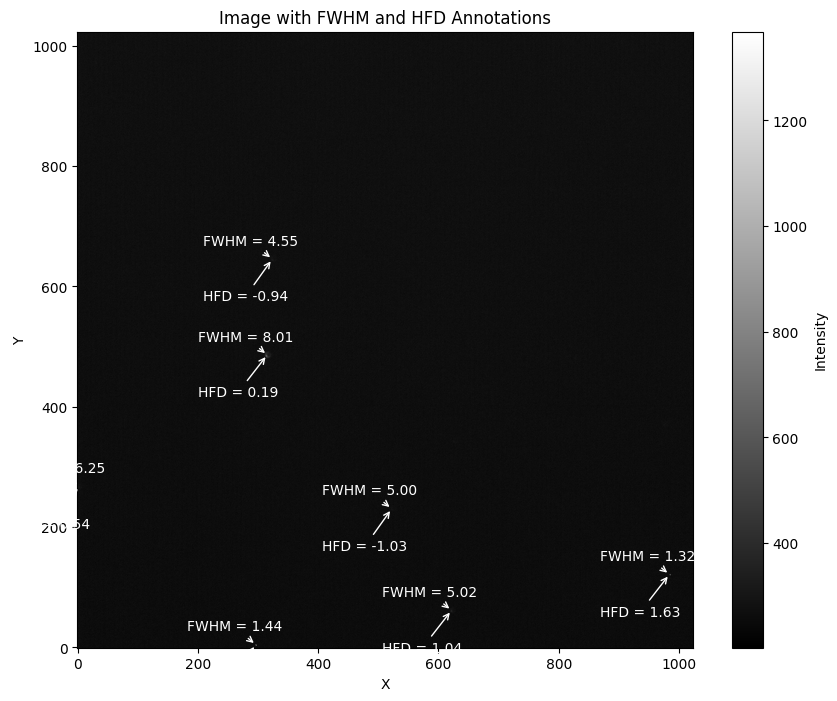

In [17]:
# Plot the image and FWHM annotations
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='gray', origin='lower')

# Add FWHM annotations
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    fwhm_value = fwhm_values[i]
    plt.annotate(f"FWHM = {fwhm_value:.2f}",
                 xy=(x, y), xycoords='data',
                 xytext=(-50, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", color='white'),
                 color='white')

# Add HFD annotations
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    hfd_value = hfd_values[i]
    plt.annotate(f"HFD = {hfd_value:.2f}",
                 xy=(x, y), xycoords='data',
                 xytext=(-50, -30), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", color='white'),
                 color='white')


plt.colorbar(label='Intensity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Image with FWHM and HFD Annotations')
plt.show()

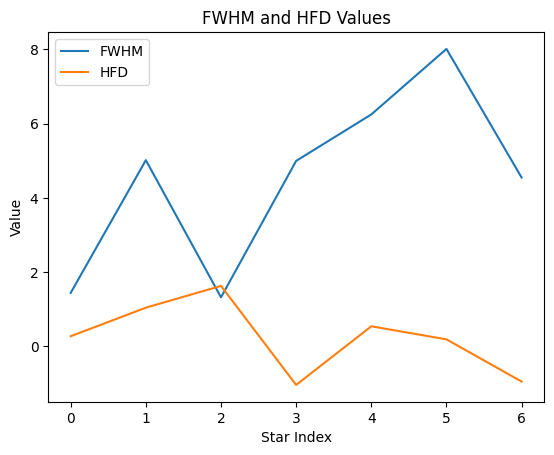

In [18]:
plt.plot(fwhm_values, label='FWHM')
plt.plot(hfd_values, label='HFD')
plt.legend()
plt.xlabel('Star Index')
plt.ylabel('Value')
plt.title('FWHM and HFD Values')
plt.show()
